In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.optim as optim
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(0.3, 0.5, 0.5),
    transforms.ToTensor(),
])

In [4]:
dataset = datasets.ImageFolder(root="../Data", transform=transform)

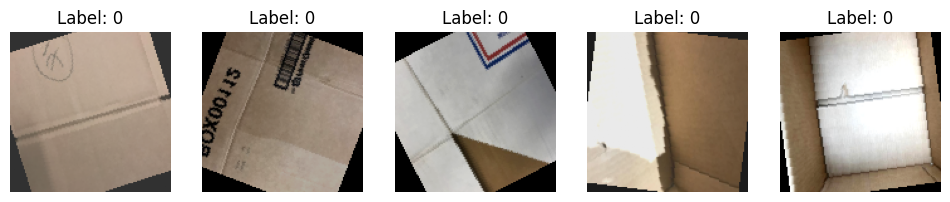

In [5]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    image, label = dataset[i]
    axs[i].imshow(image.permute(1, 2, 0))
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')
plt.show()

In [6]:
print(dataset.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [7]:
batchsize = 64

In [8]:
datasetLen = len(dataset)
train_ratio = 0.9
test_ratio = 0.1
train_size = int(train_ratio * datasetLen)
test_size = datasetLen - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchsize, shuffle=False, pin_memory=True)


In [10]:
example_train_data = iter(train_loader)
example = next(example_train_data)
print(example)

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 

In [11]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CNNModel, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.dropout_fc = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [12]:
print("HI")
for epoch in range(20):
    print("HI")
    index = 0
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, leave=True)
    for images, labels in loop:
        index+=1
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/10]")
        loop.set_postfix(loss=loss.item())
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")
    print("HO")

HI
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [1/10]:   3%|▎         | 1/36 [00:07<04:08,  7.10s/it, loss=1.82]

HI


Epoch [1/10]:   6%|▌         | 2/36 [00:11<03:11,  5.63s/it, loss=2.31]

HI


Epoch [1/10]:   8%|▊         | 3/36 [00:16<02:47,  5.08s/it, loss=1.72]

HI


Epoch [1/10]:  11%|█         | 4/36 [00:20<02:34,  4.83s/it, loss=1.7] 

HI


Epoch [1/10]:  14%|█▍        | 5/36 [00:25<02:26,  4.71s/it, loss=1.66]

HI


Epoch [1/10]:  17%|█▋        | 6/36 [00:29<02:20,  4.69s/it, loss=1.76]

HI


Epoch [1/10]:  19%|█▉        | 7/36 [00:34<02:15,  4.68s/it, loss=1.75]

HI


Epoch [1/10]:  22%|██▏       | 8/36 [00:39<02:12,  4.73s/it, loss=1.81]

HI


Epoch [1/10]:  25%|██▌       | 9/36 [00:43<02:07,  4.72s/it, loss=1.61]

HI


Epoch [1/10]:  28%|██▊       | 10/36 [00:48<02:02,  4.71s/it, loss=1.55]

HI


Epoch [1/10]:  31%|███       | 11/36 [00:55<02:12,  5.30s/it, loss=1.68]

HI


Epoch [1/10]:  33%|███▎      | 12/36 [01:00<02:05,  5.21s/it, loss=1.55]

HI


Epoch [1/10]:  36%|███▌      | 13/36 [01:05<01:59,  5.18s/it, loss=1.63]

HI


Epoch [1/10]:  39%|███▉      | 14/36 [01:10<01:50,  5.02s/it, loss=1.55]

HI


Epoch [1/10]:  42%|████▏     | 15/36 [01:14<01:42,  4.88s/it, loss=1.39]

HI


Epoch [1/10]:  44%|████▍     | 16/36 [01:19<01:38,  4.94s/it, loss=1.54]

HI


Epoch [1/10]:  47%|████▋     | 17/36 [01:24<01:35,  5.05s/it, loss=1.59]

HI


Epoch [1/10]:  50%|█████     | 18/36 [01:29<01:30,  5.01s/it, loss=1.37]

HI


Epoch [1/10]:  53%|█████▎    | 19/36 [01:34<01:25,  5.04s/it, loss=1.59]

HI


Epoch [1/10]:  56%|█████▌    | 20/36 [01:40<01:20,  5.06s/it, loss=1.51]

HI


Epoch [1/10]:  58%|█████▊    | 21/36 [01:45<01:15,  5.06s/it, loss=1.51]

HI


Epoch [1/10]:  61%|██████    | 22/36 [01:50<01:11,  5.08s/it, loss=1.37]

HI


Epoch [1/10]:  64%|██████▍   | 23/36 [01:55<01:05,  5.02s/it, loss=1.45]

HI


Epoch [1/10]:  67%|██████▋   | 24/36 [01:59<00:59,  4.95s/it, loss=1.47]

HI


Epoch [1/10]:  69%|██████▉   | 25/36 [02:05<00:55,  5.07s/it, loss=1.41]

HI


Epoch [1/10]:  72%|███████▏  | 26/36 [02:11<00:54,  5.48s/it, loss=1.63]

HI


Epoch [1/10]:  75%|███████▌  | 27/36 [02:18<00:52,  5.81s/it, loss=1.5] 

HI


Epoch [1/10]:  78%|███████▊  | 28/36 [02:22<00:43,  5.41s/it, loss=1.69]

HI


Epoch [1/10]:  81%|████████  | 29/36 [02:27<00:35,  5.12s/it, loss=1.65]

HI


Epoch [1/10]:  83%|████████▎ | 30/36 [02:33<00:33,  5.55s/it, loss=1.49]

HI


Epoch [1/10]:  86%|████████▌ | 31/36 [02:40<00:29,  5.86s/it, loss=1.35]

HI


Epoch [1/10]:  89%|████████▉ | 32/36 [02:46<00:23,  5.93s/it, loss=1.53]

HI


Epoch [1/10]:  92%|█████████▏| 33/36 [02:51<00:16,  5.62s/it, loss=1.51]

HI


Epoch [1/10]:  94%|█████████▍| 34/36 [02:55<00:10,  5.31s/it, loss=1.5] 

HI


Epoch [1/10]:  97%|█████████▋| 35/36 [03:00<00:05,  5.08s/it, loss=1.48]

HI


Epoch [1/10]: 100%|██████████| 36/36 [03:02<00:00,  5.08s/it, loss=1.48]


Epoch 1, Loss: 1.5866
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [2/10]:   3%|▎         | 1/36 [00:05<03:04,  5.28s/it, loss=1.39]

HI


Epoch [2/10]:   6%|▌         | 2/36 [00:09<02:45,  4.85s/it, loss=1.41]

HI


Epoch [2/10]:   8%|▊         | 3/36 [00:14<02:34,  4.69s/it, loss=1.47]

HI


Epoch [2/10]:  11%|█         | 4/36 [00:18<02:29,  4.66s/it, loss=1.53]

HI


Epoch [2/10]:  14%|█▍        | 5/36 [00:23<02:27,  4.77s/it, loss=1.45]

HI


Epoch [2/10]:  17%|█▋        | 6/36 [00:28<02:20,  4.67s/it, loss=1.46]

HI


Epoch [2/10]:  19%|█▉        | 7/36 [00:32<02:13,  4.62s/it, loss=1.4] 

HI


Epoch [2/10]:  22%|██▏       | 8/36 [00:37<02:09,  4.61s/it, loss=1.51]

HI


Epoch [2/10]:  25%|██▌       | 9/36 [00:42<02:04,  4.63s/it, loss=1.47]

HI


Epoch [2/10]:  28%|██▊       | 10/36 [00:48<02:14,  5.16s/it, loss=1.41]

HI


Epoch [2/10]:  31%|███       | 11/36 [00:55<02:24,  5.78s/it, loss=1.6] 

HI


Epoch [2/10]:  33%|███▎      | 12/36 [01:00<02:12,  5.52s/it, loss=1.57]

HI


Epoch [2/10]:  36%|███▌      | 13/36 [01:06<02:06,  5.51s/it, loss=1.4] 

HI


Epoch [2/10]:  39%|███▉      | 14/36 [01:11<02:01,  5.51s/it, loss=1.44]

HI


Epoch [2/10]:  42%|████▏     | 15/36 [01:17<01:59,  5.69s/it, loss=1.39]

HI


Epoch [2/10]:  44%|████▍     | 16/36 [01:22<01:50,  5.55s/it, loss=1.42]

HI


Epoch [2/10]:  47%|████▋     | 17/36 [01:29<01:48,  5.70s/it, loss=1.45]

HI


Epoch [2/10]:  50%|█████     | 18/36 [01:34<01:41,  5.66s/it, loss=1.41]

HI


Epoch [2/10]:  53%|█████▎    | 19/36 [01:39<01:32,  5.45s/it, loss=1.44]

HI


Epoch [2/10]:  56%|█████▌    | 20/36 [01:44<01:23,  5.25s/it, loss=1.49]

HI


Epoch [2/10]:  58%|█████▊    | 21/36 [01:49<01:17,  5.19s/it, loss=1.42]

HI


Epoch [2/10]:  61%|██████    | 22/36 [01:54<01:10,  5.03s/it, loss=1.51]

HI


Epoch [2/10]:  64%|██████▍   | 23/36 [01:58<01:04,  4.95s/it, loss=1.34]

HI


Epoch [2/10]:  67%|██████▋   | 24/36 [02:03<00:57,  4.81s/it, loss=1.53]

HI


Epoch [2/10]:  69%|██████▉   | 25/36 [02:07<00:51,  4.65s/it, loss=1.48]

HI


Epoch [2/10]:  72%|███████▏  | 26/36 [02:12<00:46,  4.65s/it, loss=1.53]

HI


Epoch [2/10]:  75%|███████▌  | 27/36 [02:17<00:42,  4.75s/it, loss=1.25]

HI


Epoch [2/10]:  78%|███████▊  | 28/36 [02:22<00:39,  4.92s/it, loss=1.49]

HI


Epoch [2/10]:  81%|████████  | 29/36 [02:27<00:35,  5.03s/it, loss=1.35]

HI


Epoch [2/10]:  83%|████████▎ | 30/36 [02:32<00:29,  4.93s/it, loss=1.23]

HI


Epoch [2/10]:  86%|████████▌ | 31/36 [02:37<00:24,  4.81s/it, loss=1.4] 

HI


Epoch [2/10]:  89%|████████▉ | 32/36 [02:43<00:21,  5.25s/it, loss=1.4]

HI


Epoch [2/10]:  92%|█████████▏| 33/36 [02:51<00:18,  6.07s/it, loss=1.38]

HI


Epoch [2/10]:  94%|█████████▍| 34/36 [02:57<00:11,  5.99s/it, loss=1.31]

HI


Epoch [2/10]:  97%|█████████▋| 35/36 [03:02<00:05,  5.69s/it, loss=1.36]

HI


Epoch [2/10]: 100%|██████████| 36/36 [03:05<00:00,  5.15s/it, loss=1.24]


Epoch 2, Loss: 1.4258
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [3/10]:   3%|▎         | 1/36 [00:05<03:21,  5.75s/it, loss=1.19]

HI


Epoch [3/10]:   6%|▌         | 2/36 [00:11<03:06,  5.49s/it, loss=1.54]

HI


Epoch [3/10]:   8%|▊         | 3/36 [00:16<02:56,  5.34s/it, loss=1.41]

HI


Epoch [3/10]:  11%|█         | 4/36 [00:21<02:52,  5.38s/it, loss=1.27]

HI


Epoch [3/10]:  14%|█▍        | 5/36 [00:26<02:43,  5.28s/it, loss=1.39]

HI


Epoch [3/10]:  17%|█▋        | 6/36 [00:32<02:40,  5.34s/it, loss=1.36]

HI


Epoch [3/10]:  19%|█▉        | 7/36 [00:37<02:33,  5.28s/it, loss=1.38]

HI


Epoch [3/10]:  22%|██▏       | 8/36 [00:43<02:31,  5.40s/it, loss=1.34]

HI


Epoch [3/10]:  25%|██▌       | 9/36 [00:48<02:23,  5.30s/it, loss=1.28]

HI


Epoch [3/10]:  28%|██▊       | 10/36 [00:52<02:12,  5.10s/it, loss=1.36]

HI


Epoch [3/10]:  31%|███       | 11/36 [00:57<02:03,  4.95s/it, loss=1.4] 

HI


Epoch [3/10]:  33%|███▎      | 12/36 [01:01<01:55,  4.81s/it, loss=1.33]

HI


Epoch [3/10]:  36%|███▌      | 13/36 [01:06<01:48,  4.71s/it, loss=1.42]

HI


Epoch [3/10]:  39%|███▉      | 14/36 [01:10<01:42,  4.67s/it, loss=1.4] 

HI


Epoch [3/10]:  42%|████▏     | 15/36 [01:15<01:38,  4.68s/it, loss=1.4]

HI


Epoch [3/10]:  44%|████▍     | 16/36 [01:20<01:33,  4.65s/it, loss=1.49]

HI


Epoch [3/10]:  47%|████▋     | 17/36 [01:24<01:27,  4.61s/it, loss=1.41]

HI


Epoch [3/10]:  50%|█████     | 18/36 [01:29<01:24,  4.70s/it, loss=1.42]

HI


Epoch [3/10]:  53%|█████▎    | 19/36 [01:34<01:20,  4.71s/it, loss=1.3] 

HI


Epoch [3/10]:  56%|█████▌    | 20/36 [01:38<01:14,  4.65s/it, loss=1.34]

HI


Epoch [3/10]:  58%|█████▊    | 21/36 [01:43<01:08,  4.60s/it, loss=1.31]

HI


Epoch [3/10]:  61%|██████    | 22/36 [01:47<01:03,  4.56s/it, loss=1.46]

HI


Epoch [3/10]:  64%|██████▍   | 23/36 [01:52<00:59,  4.58s/it, loss=1.26]

HI


Epoch [3/10]:  67%|██████▋   | 24/36 [01:56<00:54,  4.51s/it, loss=1.39]

HI


Epoch [3/10]:  69%|██████▉   | 25/36 [02:01<00:49,  4.49s/it, loss=1.28]

HI


Epoch [3/10]:  72%|███████▏  | 26/36 [02:05<00:44,  4.45s/it, loss=1.29]

HI


Epoch [3/10]:  75%|███████▌  | 27/36 [02:10<00:40,  4.45s/it, loss=1.31]

HI


Epoch [3/10]:  78%|███████▊  | 28/36 [02:14<00:36,  4.54s/it, loss=1.24]

HI


Epoch [3/10]:  81%|████████  | 29/36 [02:19<00:31,  4.46s/it, loss=1.56]

HI


Epoch [3/10]:  83%|████████▎ | 30/36 [02:23<00:26,  4.42s/it, loss=1.34]

HI


Epoch [3/10]:  86%|████████▌ | 31/36 [02:27<00:21,  4.40s/it, loss=1.27]

HI


Epoch [3/10]:  89%|████████▉ | 32/36 [02:32<00:17,  4.38s/it, loss=1.33]

HI


Epoch [3/10]:  92%|█████████▏| 33/36 [02:36<00:13,  4.34s/it, loss=1.38]

HI


Epoch [3/10]:  94%|█████████▍| 34/36 [02:40<00:08,  4.42s/it, loss=1.26]

HI


Epoch [3/10]:  97%|█████████▋| 35/36 [02:45<00:04,  4.44s/it, loss=1.16]

HI


Epoch [3/10]: 100%|██████████| 36/36 [02:47<00:00,  4.66s/it, loss=1.36]


Epoch 3, Loss: 1.3508
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [4/10]:   3%|▎         | 1/36 [00:05<02:57,  5.08s/it, loss=1.19]

HI


Epoch [4/10]:   6%|▌         | 2/36 [00:09<02:40,  4.72s/it, loss=1.18]

HI


Epoch [4/10]:   8%|▊         | 3/36 [00:14<02:32,  4.61s/it, loss=1.4] 

HI


Epoch [4/10]:  11%|█         | 4/36 [00:18<02:26,  4.59s/it, loss=1.17]

HI


Epoch [4/10]:  14%|█▍        | 5/36 [00:23<02:21,  4.57s/it, loss=1.31]

HI


Epoch [4/10]:  17%|█▋        | 6/36 [00:27<02:16,  4.55s/it, loss=1.37]

HI


Epoch [4/10]:  19%|█▉        | 7/36 [00:32<02:10,  4.51s/it, loss=1.3] 

HI


Epoch [4/10]:  22%|██▏       | 8/36 [00:36<02:07,  4.56s/it, loss=1.3]

HI


Epoch [4/10]:  25%|██▌       | 9/36 [00:41<02:05,  4.64s/it, loss=1.45]

HI


Epoch [4/10]:  28%|██▊       | 10/36 [00:46<02:02,  4.71s/it, loss=1.24]

HI


Epoch [4/10]:  31%|███       | 11/36 [00:51<01:57,  4.69s/it, loss=1.41]

HI


Epoch [4/10]:  33%|███▎      | 12/36 [00:56<01:56,  4.83s/it, loss=1.41]

HI


Epoch [4/10]:  36%|███▌      | 13/36 [01:01<01:52,  4.90s/it, loss=1.23]

HI


Epoch [4/10]:  39%|███▉      | 14/36 [01:05<01:44,  4.77s/it, loss=1.21]

HI


Epoch [4/10]:  42%|████▏     | 15/36 [01:10<01:42,  4.87s/it, loss=1.41]

HI


Epoch [4/10]:  44%|████▍     | 16/36 [01:15<01:37,  4.88s/it, loss=1.4] 

HI


Epoch [4/10]:  47%|████▋     | 17/36 [01:20<01:31,  4.79s/it, loss=1.29]

HI


Epoch [4/10]:  50%|█████     | 18/36 [01:24<01:24,  4.72s/it, loss=1.27]

HI


Epoch [4/10]:  53%|█████▎    | 19/36 [01:29<01:19,  4.70s/it, loss=1.33]

HI


Epoch [4/10]:  56%|█████▌    | 20/36 [01:34<01:14,  4.68s/it, loss=1.23]

HI


Epoch [4/10]:  58%|█████▊    | 21/36 [01:38<01:09,  4.66s/it, loss=1.21]

HI


Epoch [4/10]:  61%|██████    | 22/36 [01:43<01:04,  4.60s/it, loss=1.28]

HI


Epoch [4/10]:  64%|██████▍   | 23/36 [01:47<00:59,  4.55s/it, loss=1.3] 

HI


Epoch [4/10]:  67%|██████▋   | 24/36 [01:51<00:53,  4.48s/it, loss=1.41]

HI


Epoch [4/10]:  69%|██████▉   | 25/36 [01:56<00:49,  4.48s/it, loss=1.16]

HI


Epoch [4/10]:  72%|███████▏  | 26/36 [02:00<00:44,  4.47s/it, loss=1.19]

HI


Epoch [4/10]:  75%|███████▌  | 27/36 [02:05<00:40,  4.48s/it, loss=1.43]

HI


Epoch [4/10]:  78%|███████▊  | 28/36 [02:10<00:36,  4.52s/it, loss=1.11]

HI


Epoch [4/10]:  81%|████████  | 29/36 [02:14<00:31,  4.51s/it, loss=1.37]

HI


Epoch [4/10]:  83%|████████▎ | 30/36 [02:18<00:26,  4.48s/it, loss=1.42]

HI


Epoch [4/10]:  86%|████████▌ | 31/36 [02:23<00:22,  4.46s/it, loss=1.31]

HI


Epoch [4/10]:  89%|████████▉ | 32/36 [02:27<00:17,  4.41s/it, loss=1.26]

HI


Epoch [4/10]:  92%|█████████▏| 33/36 [02:31<00:13,  4.38s/it, loss=1.37]

HI


Epoch [4/10]:  94%|█████████▍| 34/36 [02:36<00:08,  4.36s/it, loss=1.16]

HI


Epoch [4/10]:  97%|█████████▋| 35/36 [02:40<00:04,  4.33s/it, loss=1.32]

HI


Epoch [4/10]: 100%|██████████| 36/36 [02:42<00:00,  4.52s/it, loss=1.04]


Epoch 4, Loss: 1.2894
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [5/10]:   3%|▎         | 1/36 [00:04<02:52,  4.93s/it, loss=1.19]

HI


Epoch [5/10]:   6%|▌         | 2/36 [00:09<02:32,  4.49s/it, loss=1.33]

HI


Epoch [5/10]:   8%|▊         | 3/36 [00:13<02:25,  4.41s/it, loss=1.23]

HI


Epoch [5/10]:  11%|█         | 4/36 [00:17<02:19,  4.36s/it, loss=1.24]

HI


Epoch [5/10]:  14%|█▍        | 5/36 [00:22<02:17,  4.44s/it, loss=1.32]

HI


Epoch [5/10]:  17%|█▋        | 6/36 [00:26<02:15,  4.53s/it, loss=1.16]

HI


Epoch [5/10]:  19%|█▉        | 7/36 [00:31<02:11,  4.53s/it, loss=1.35]

HI


Epoch [5/10]:  22%|██▏       | 8/36 [00:36<02:06,  4.52s/it, loss=1.3] 

HI


Epoch [5/10]:  25%|██▌       | 9/36 [00:40<02:02,  4.53s/it, loss=1.21]

HI


Epoch [5/10]:  28%|██▊       | 10/36 [00:44<01:56,  4.49s/it, loss=1.38]

HI


Epoch [5/10]:  31%|███       | 11/36 [00:49<01:51,  4.45s/it, loss=1.41]

HI


Epoch [5/10]:  33%|███▎      | 12/36 [00:53<01:47,  4.48s/it, loss=1.31]

HI


Epoch [5/10]:  36%|███▌      | 13/36 [00:58<01:42,  4.46s/it, loss=1.15]

HI


Epoch [5/10]:  39%|███▉      | 14/36 [01:02<01:38,  4.48s/it, loss=1.17]

HI


Epoch [5/10]:  42%|████▏     | 15/36 [01:07<01:33,  4.47s/it, loss=1.32]

HI


Epoch [5/10]:  44%|████▍     | 16/36 [01:11<01:29,  4.46s/it, loss=1.16]

HI


Epoch [5/10]:  47%|████▋     | 17/36 [01:16<01:24,  4.46s/it, loss=1.27]

HI


Epoch [5/10]:  50%|█████     | 18/36 [01:20<01:21,  4.50s/it, loss=1.37]

HI


Epoch [5/10]:  53%|█████▎    | 19/36 [01:25<01:17,  4.55s/it, loss=1.22]

HI


Epoch [5/10]:  56%|█████▌    | 20/36 [01:29<01:12,  4.52s/it, loss=1.23]

HI


Epoch [5/10]:  58%|█████▊    | 21/36 [01:34<01:06,  4.46s/it, loss=1.14]

HI


Epoch [5/10]:  61%|██████    | 22/36 [01:38<01:01,  4.42s/it, loss=1.41]

HI


Epoch [5/10]:  64%|██████▍   | 23/36 [01:42<00:56,  4.38s/it, loss=1.18]

HI


Epoch [5/10]:  67%|██████▋   | 24/36 [01:47<00:52,  4.41s/it, loss=1.12]

HI


Epoch [5/10]:  69%|██████▉   | 25/36 [01:51<00:48,  4.42s/it, loss=1.17]

HI


Epoch [5/10]:  72%|███████▏  | 26/36 [01:56<00:44,  4.46s/it, loss=1.05]

HI


Epoch [5/10]:  75%|███████▌  | 27/36 [02:00<00:39,  4.43s/it, loss=1.3] 

HI


Epoch [5/10]:  78%|███████▊  | 28/36 [02:04<00:35,  4.38s/it, loss=1.08]

HI


Epoch [5/10]:  81%|████████  | 29/36 [02:09<00:30,  4.40s/it, loss=1.13]

HI


Epoch [5/10]:  83%|████████▎ | 30/36 [02:13<00:26,  4.43s/it, loss=1.25]

HI


Epoch [5/10]:  86%|████████▌ | 31/36 [02:18<00:22,  4.43s/it, loss=1.23]

HI


Epoch [5/10]:  89%|████████▉ | 32/36 [02:22<00:17,  4.45s/it, loss=1.26]

HI


Epoch [5/10]:  92%|█████████▏| 33/36 [02:27<00:13,  4.47s/it, loss=1.18]

HI


Epoch [5/10]:  94%|█████████▍| 34/36 [02:31<00:08,  4.44s/it, loss=1.26]

HI


Epoch [5/10]:  97%|█████████▋| 35/36 [02:36<00:04,  4.46s/it, loss=1.1] 

HI


Epoch [5/10]: 100%|██████████| 36/36 [02:38<00:00,  4.41s/it, loss=1.36]


Epoch 5, Loss: 1.2373
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [6/10]:   3%|▎         | 1/36 [00:04<02:53,  4.97s/it, loss=1.29]

HI


Epoch [6/10]:   6%|▌         | 2/36 [00:09<02:37,  4.65s/it, loss=1.18]

HI


Epoch [6/10]:   8%|▊         | 3/36 [00:14<02:34,  4.69s/it, loss=1.14]

HI


Epoch [6/10]:  11%|█         | 4/36 [00:18<02:28,  4.65s/it, loss=1.18]

HI


Epoch [6/10]:  14%|█▍        | 5/36 [00:23<02:22,  4.60s/it, loss=1.21]

HI


Epoch [6/10]:  17%|█▋        | 6/36 [00:27<02:16,  4.55s/it, loss=1.23]

HI


Epoch [6/10]:  19%|█▉        | 7/36 [00:32<02:10,  4.51s/it, loss=1.23]

HI


Epoch [6/10]:  22%|██▏       | 8/36 [00:36<02:05,  4.49s/it, loss=1.07]

HI


Epoch [6/10]:  25%|██▌       | 9/36 [00:40<02:00,  4.47s/it, loss=1.29]

HI


Epoch [6/10]:  28%|██▊       | 10/36 [00:45<01:59,  4.59s/it, loss=1.27]

HI


Epoch [6/10]:  31%|███       | 11/36 [00:50<01:54,  4.57s/it, loss=1.13]

HI


Epoch [6/10]:  33%|███▎      | 12/36 [00:54<01:48,  4.53s/it, loss=1.12]

HI


Epoch [6/10]:  36%|███▌      | 13/36 [00:59<01:43,  4.51s/it, loss=1.41]

HI


Epoch [6/10]:  39%|███▉      | 14/36 [01:03<01:38,  4.49s/it, loss=1.26]

HI


Epoch [6/10]:  42%|████▏     | 15/36 [01:08<01:34,  4.50s/it, loss=1.07]

HI


Epoch [6/10]:  44%|████▍     | 16/36 [01:12<01:29,  4.48s/it, loss=1.13]

HI


Epoch [6/10]:  47%|████▋     | 17/36 [01:17<01:25,  4.49s/it, loss=1.13]

HI


Epoch [6/10]:  50%|█████     | 18/36 [01:21<01:20,  4.47s/it, loss=1.12]

HI


Epoch [6/10]:  53%|█████▎    | 19/36 [01:26<01:16,  4.50s/it, loss=1.1] 

HI


Epoch [6/10]:  56%|█████▌    | 20/36 [01:30<01:11,  4.48s/it, loss=1.12]

HI


Epoch [6/10]:  58%|█████▊    | 21/36 [01:35<01:07,  4.51s/it, loss=1.22]

HI


Epoch [6/10]:  61%|██████    | 22/36 [01:39<01:03,  4.53s/it, loss=1.25]

HI


Epoch [6/10]:  64%|██████▍   | 23/36 [01:44<01:00,  4.64s/it, loss=1.07]

HI


Epoch [6/10]:  67%|██████▋   | 24/36 [01:49<00:55,  4.62s/it, loss=1.18]

HI


Epoch [6/10]:  69%|██████▉   | 25/36 [01:53<00:50,  4.57s/it, loss=1.19]

HI


Epoch [6/10]:  72%|███████▏  | 26/36 [01:58<00:45,  4.57s/it, loss=1.26]

HI


Epoch [6/10]:  75%|███████▌  | 27/36 [02:02<00:40,  4.54s/it, loss=1.21]

HI


Epoch [6/10]:  78%|███████▊  | 28/36 [02:07<00:35,  4.49s/it, loss=1.34]

HI


Epoch [6/10]:  81%|████████  | 29/36 [02:11<00:31,  4.52s/it, loss=1.16]

HI


Epoch [6/10]:  83%|████████▎ | 30/36 [02:16<00:26,  4.47s/it, loss=1.05]

HI


Epoch [6/10]:  86%|████████▌ | 31/36 [02:20<00:22,  4.44s/it, loss=1.16]

HI


Epoch [6/10]:  89%|████████▉ | 32/36 [02:24<00:17,  4.47s/it, loss=1.28]

HI


Epoch [6/10]:  92%|█████████▏| 33/36 [02:29<00:13,  4.46s/it, loss=1.18]

HI


Epoch [6/10]:  94%|█████████▍| 34/36 [02:33<00:08,  4.41s/it, loss=1.23]

HI


Epoch [6/10]:  97%|█████████▋| 35/36 [02:38<00:04,  4.42s/it, loss=1.21]

HI


Epoch [6/10]: 100%|██████████| 36/36 [02:40<00:00,  4.46s/it, loss=1.05]


Epoch 6, Loss: 1.1851
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [7/10]:   3%|▎         | 1/36 [00:04<02:54,  4.98s/it, loss=1.05]

HI


Epoch [7/10]:   6%|▌         | 2/36 [00:09<02:39,  4.68s/it, loss=1.16]

HI


Epoch [7/10]:   8%|▊         | 3/36 [00:13<02:29,  4.52s/it, loss=1.25]

HI


Epoch [7/10]:  11%|█         | 4/36 [00:18<02:23,  4.48s/it, loss=1.09]

HI


Epoch [7/10]:  14%|█▍        | 5/36 [00:22<02:17,  4.44s/it, loss=1.18]

HI


Epoch [7/10]:  17%|█▋        | 6/36 [00:26<02:12,  4.43s/it, loss=1.28]

HI


Epoch [7/10]:  19%|█▉        | 7/36 [00:31<02:08,  4.45s/it, loss=1.09]

HI


Epoch [7/10]:  22%|██▏       | 8/36 [00:36<02:05,  4.48s/it, loss=1.09]

HI


Epoch [7/10]:  25%|██▌       | 9/36 [00:40<02:01,  4.50s/it, loss=1.14]

HI


Epoch [7/10]:  28%|██▊       | 10/36 [00:45<01:57,  4.50s/it, loss=1.21]

HI


Epoch [7/10]:  31%|███       | 11/36 [00:49<01:53,  4.54s/it, loss=1.23]

HI


Epoch [7/10]:  33%|███▎      | 12/36 [00:54<01:49,  4.56s/it, loss=0.994]

HI


Epoch [7/10]:  36%|███▌      | 13/36 [00:58<01:44,  4.55s/it, loss=1.18] 

HI


Epoch [7/10]:  39%|███▉      | 14/36 [01:03<01:41,  4.61s/it, loss=1.26]

HI


Epoch [7/10]:  42%|████▏     | 15/36 [01:08<01:37,  4.63s/it, loss=1.03]

HI


Epoch [7/10]:  44%|████▍     | 16/36 [01:12<01:32,  4.63s/it, loss=1.16]

HI


Epoch [7/10]:  47%|████▋     | 17/36 [01:17<01:28,  4.65s/it, loss=1.15]

HI


Epoch [7/10]:  50%|█████     | 18/36 [01:22<01:23,  4.65s/it, loss=1.14]

HI


Epoch [7/10]:  53%|█████▎    | 19/36 [01:26<01:18,  4.63s/it, loss=1.04]

HI


Epoch [7/10]:  56%|█████▌    | 20/36 [01:32<01:17,  4.83s/it, loss=1.16]

HI


Epoch [7/10]:  58%|█████▊    | 21/36 [01:36<01:11,  4.78s/it, loss=0.994]

HI


Epoch [7/10]:  61%|██████    | 22/36 [01:41<01:06,  4.78s/it, loss=1.16] 

HI


Epoch [7/10]:  64%|██████▍   | 23/36 [01:46<01:01,  4.73s/it, loss=1.2] 

HI


Epoch [7/10]:  67%|██████▋   | 24/36 [01:50<00:56,  4.75s/it, loss=1.27]

HI


Epoch [7/10]:  69%|██████▉   | 25/36 [01:55<00:51,  4.68s/it, loss=1.27]

HI


Epoch [7/10]:  72%|███████▏  | 26/36 [02:00<00:47,  4.72s/it, loss=1.05]

HI


Epoch [7/10]:  75%|███████▌  | 27/36 [02:04<00:41,  4.66s/it, loss=1.22]

HI


Epoch [7/10]:  78%|███████▊  | 28/36 [02:09<00:37,  4.68s/it, loss=1.17]

HI


Epoch [7/10]:  81%|████████  | 29/36 [02:14<00:33,  4.84s/it, loss=1.06]

HI


Epoch [7/10]:  83%|████████▎ | 30/36 [02:19<00:29,  4.94s/it, loss=0.969]

HI


Epoch [7/10]:  86%|████████▌ | 31/36 [02:24<00:24,  4.87s/it, loss=1.01] 

HI


Epoch [7/10]:  89%|████████▉ | 32/36 [02:29<00:19,  4.85s/it, loss=1.19]

HI


Epoch [7/10]:  92%|█████████▏| 33/36 [02:34<00:14,  4.94s/it, loss=1.15]

HI


Epoch [7/10]:  94%|█████████▍| 34/36 [02:39<00:09,  4.79s/it, loss=1.2] 

HI


Epoch [7/10]:  97%|█████████▋| 35/36 [02:43<00:04,  4.65s/it, loss=1.25]

HI


Epoch [7/10]: 100%|██████████| 36/36 [02:45<00:00,  4.60s/it, loss=1.14]


Epoch 7, Loss: 1.1439
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [8/10]:   3%|▎         | 1/36 [00:05<03:29,  5.99s/it, loss=1.18]

HI


Epoch [8/10]:   6%|▌         | 2/36 [00:10<02:52,  5.09s/it, loss=1.08]

HI


Epoch [8/10]:   8%|▊         | 3/36 [00:15<02:39,  4.85s/it, loss=1.15]

HI


Epoch [8/10]:  11%|█         | 4/36 [00:19<02:31,  4.73s/it, loss=1.12]

HI


Epoch [8/10]:  14%|█▍        | 5/36 [00:23<02:21,  4.58s/it, loss=1.16]

HI


Epoch [8/10]:  17%|█▋        | 6/36 [00:28<02:17,  4.59s/it, loss=1.07]

HI


Epoch [8/10]:  19%|█▉        | 7/36 [00:33<02:13,  4.62s/it, loss=1.18]

HI


Epoch [8/10]:  22%|██▏       | 8/36 [00:37<02:08,  4.58s/it, loss=1.2] 

HI


Epoch [8/10]:  25%|██▌       | 9/36 [00:42<02:01,  4.52s/it, loss=1.15]

HI


Epoch [8/10]:  28%|██▊       | 10/36 [00:46<01:56,  4.50s/it, loss=1.21]

HI


Epoch [8/10]:  31%|███       | 11/36 [00:50<01:51,  4.45s/it, loss=1.05]

HI


Epoch [8/10]:  33%|███▎      | 12/36 [00:55<01:47,  4.47s/it, loss=1.3] 

HI


Epoch [8/10]:  36%|███▌      | 13/36 [00:59<01:43,  4.49s/it, loss=1.03]

HI


Epoch [8/10]:  39%|███▉      | 14/36 [01:04<01:38,  4.49s/it, loss=1.11]

HI


Epoch [8/10]:  42%|████▏     | 15/36 [01:08<01:34,  4.51s/it, loss=1.24]

HI


Epoch [8/10]:  44%|████▍     | 16/36 [01:13<01:31,  4.56s/it, loss=1.04]

HI


Epoch [8/10]:  47%|████▋     | 17/36 [01:18<01:27,  4.61s/it, loss=1.19]

HI


Epoch [8/10]:  50%|█████     | 18/36 [01:22<01:23,  4.62s/it, loss=1.26]

HI


Epoch [8/10]:  53%|█████▎    | 19/36 [01:27<01:17,  4.59s/it, loss=1]   

HI


Epoch [8/10]:  56%|█████▌    | 20/36 [01:31<01:12,  4.53s/it, loss=1]

HI


Epoch [8/10]:  58%|█████▊    | 21/36 [01:36<01:06,  4.46s/it, loss=1.14]

HI


Epoch [8/10]:  61%|██████    | 22/36 [01:40<01:01,  4.40s/it, loss=1.18]

HI


Epoch [8/10]:  64%|██████▍   | 23/36 [01:44<00:56,  4.35s/it, loss=1.13]

HI


Epoch [8/10]:  67%|██████▋   | 24/36 [01:48<00:51,  4.32s/it, loss=1.18]

HI


Epoch [8/10]:  69%|██████▉   | 25/36 [01:53<00:48,  4.37s/it, loss=1.16]

HI


Epoch [8/10]:  72%|███████▏  | 26/36 [01:57<00:43,  4.35s/it, loss=1.03]

HI


Epoch [8/10]:  75%|███████▌  | 27/36 [02:02<00:39,  4.34s/it, loss=1.09]

HI


Epoch [8/10]:  78%|███████▊  | 28/36 [02:06<00:34,  4.33s/it, loss=1.04]

HI


Epoch [8/10]:  81%|████████  | 29/36 [02:10<00:30,  4.31s/it, loss=1.01]

HI


Epoch [8/10]:  83%|████████▎ | 30/36 [02:14<00:25,  4.27s/it, loss=1.19]

HI


Epoch [8/10]:  86%|████████▌ | 31/36 [02:19<00:21,  4.28s/it, loss=0.967]

HI


Epoch [8/10]:  89%|████████▉ | 32/36 [02:23<00:16,  4.25s/it, loss=1.09] 

HI


Epoch [8/10]:  92%|█████████▏| 33/36 [02:27<00:12,  4.26s/it, loss=1.15]

HI


Epoch [8/10]:  94%|█████████▍| 34/36 [02:31<00:08,  4.23s/it, loss=1.21]

HI


Epoch [8/10]:  97%|█████████▋| 35/36 [02:35<00:04,  4.22s/it, loss=1.14]

HI


Epoch [8/10]: 100%|██████████| 36/36 [02:38<00:00,  4.40s/it, loss=1.17]


Epoch 8, Loss: 1.1280
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [9/10]:   3%|▎         | 1/36 [00:04<02:50,  4.86s/it, loss=1.1]

HI


Epoch [9/10]:   6%|▌         | 2/36 [00:09<02:32,  4.48s/it, loss=1.17]

HI


Epoch [9/10]:   8%|▊         | 3/36 [00:13<02:32,  4.63s/it, loss=1.15]

HI


Epoch [9/10]:  11%|█         | 4/36 [00:18<02:24,  4.51s/it, loss=0.977]

HI


Epoch [9/10]:  14%|█▍        | 5/36 [00:22<02:18,  4.45s/it, loss=1.18] 

HI


Epoch [9/10]:  17%|█▋        | 6/36 [00:27<02:13,  4.46s/it, loss=0.999]

HI


Epoch [9/10]:  19%|█▉        | 7/36 [00:31<02:09,  4.48s/it, loss=1.13] 

HI


Epoch [9/10]:  22%|██▏       | 8/36 [00:35<02:04,  4.46s/it, loss=1.23]

HI


Epoch [9/10]:  25%|██▌       | 9/36 [00:40<02:01,  4.51s/it, loss=1.24]

HI


Epoch [9/10]:  28%|██▊       | 10/36 [00:44<01:56,  4.47s/it, loss=1.16]

HI


Epoch [9/10]:  31%|███       | 11/36 [00:50<01:58,  4.76s/it, loss=1.08]

HI


Epoch [9/10]:  33%|███▎      | 12/36 [00:55<01:59,  4.99s/it, loss=1.03]

HI


Epoch [9/10]:  36%|███▌      | 13/36 [01:00<01:55,  5.00s/it, loss=1.05]

HI


Epoch [9/10]:  39%|███▉      | 14/36 [01:05<01:47,  4.87s/it, loss=1.23]

HI


Epoch [9/10]:  42%|████▏     | 15/36 [01:10<01:43,  4.95s/it, loss=1.08]

HI


Epoch [9/10]:  44%|████▍     | 16/36 [01:15<01:39,  4.98s/it, loss=1.24]

HI


Epoch [9/10]:  47%|████▋     | 17/36 [01:20<01:33,  4.92s/it, loss=1.01]

HI


Epoch [9/10]:  50%|█████     | 18/36 [01:25<01:30,  5.05s/it, loss=1.07]

HI


Epoch [9/10]:  53%|█████▎    | 19/36 [01:30<01:23,  4.91s/it, loss=1.03]

HI


Epoch [9/10]:  56%|█████▌    | 20/36 [01:35<01:17,  4.84s/it, loss=1.05]

HI


Epoch [9/10]:  58%|█████▊    | 21/36 [01:40<01:13,  4.88s/it, loss=1.16]

HI


Epoch [9/10]:  61%|██████    | 22/36 [01:44<01:07,  4.80s/it, loss=1.09]

HI


Epoch [9/10]:  64%|██████▍   | 23/36 [01:49<01:02,  4.78s/it, loss=1.13]

HI


Epoch [9/10]:  67%|██████▋   | 24/36 [01:54<00:58,  4.86s/it, loss=1.08]

HI


Epoch [9/10]:  69%|██████▉   | 25/36 [01:59<00:52,  4.82s/it, loss=1.03]

HI


Epoch [9/10]:  72%|███████▏  | 26/36 [02:03<00:47,  4.73s/it, loss=1.09]

HI


Epoch [9/10]:  75%|███████▌  | 27/36 [02:08<00:42,  4.72s/it, loss=1.27]

HI


Epoch [9/10]:  78%|███████▊  | 28/36 [02:12<00:37,  4.67s/it, loss=0.997]

HI


Epoch [9/10]:  81%|████████  | 29/36 [02:17<00:31,  4.55s/it, loss=1.08] 

HI


Epoch [9/10]:  83%|████████▎ | 30/36 [02:21<00:26,  4.47s/it, loss=1.22]

HI


Epoch [9/10]:  86%|████████▌ | 31/36 [02:25<00:22,  4.40s/it, loss=1.02]

HI


Epoch [9/10]:  89%|████████▉ | 32/36 [02:29<00:17,  4.35s/it, loss=1.13]

HI


Epoch [9/10]:  92%|█████████▏| 33/36 [02:34<00:12,  4.32s/it, loss=1.2] 

HI


Epoch [9/10]:  94%|█████████▍| 34/36 [02:38<00:08,  4.30s/it, loss=1.18]

HI


Epoch [9/10]:  97%|█████████▋| 35/36 [02:42<00:04,  4.28s/it, loss=1.27]

HI


Epoch [9/10]: 100%|██████████| 36/36 [02:45<00:00,  4.59s/it, loss=1.32]


Epoch 9, Loss: 1.1244
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [10/10]:   3%|▎         | 1/36 [00:04<02:50,  4.88s/it, loss=1.05]

HI


Epoch [10/10]:   6%|▌         | 2/36 [00:09<02:31,  4.47s/it, loss=1.3] 

HI


Epoch [10/10]:   8%|▊         | 3/36 [00:13<02:25,  4.41s/it, loss=0.92]

HI


Epoch [10/10]:  11%|█         | 4/36 [00:17<02:19,  4.35s/it, loss=1.03]

HI


Epoch [10/10]:  14%|█▍        | 5/36 [00:22<02:15,  4.37s/it, loss=1.07]

HI


Epoch [10/10]:  17%|█▋        | 6/36 [00:26<02:10,  4.35s/it, loss=1.07]

HI


Epoch [10/10]:  19%|█▉        | 7/36 [00:30<02:04,  4.31s/it, loss=1.02]

HI


Epoch [10/10]:  22%|██▏       | 8/36 [00:34<02:00,  4.31s/it, loss=1.2] 

HI


Epoch [10/10]:  25%|██▌       | 9/36 [00:39<01:56,  4.31s/it, loss=0.983]

HI


Epoch [10/10]:  28%|██▊       | 10/36 [00:43<01:52,  4.31s/it, loss=1.2] 

HI


Epoch [10/10]:  31%|███       | 11/36 [00:48<01:49,  4.38s/it, loss=1.04]

HI


Epoch [10/10]:  33%|███▎      | 12/36 [00:52<01:48,  4.52s/it, loss=1.07]

HI


Epoch [10/10]:  36%|███▌      | 13/36 [00:57<01:43,  4.49s/it, loss=1.18]

HI


Epoch [10/10]:  39%|███▉      | 14/36 [01:01<01:37,  4.45s/it, loss=1.29]

HI


Epoch [10/10]:  42%|████▏     | 15/36 [01:06<01:33,  4.45s/it, loss=0.987]

HI


Epoch [10/10]:  44%|████▍     | 16/36 [01:10<01:28,  4.41s/it, loss=1]    

HI


Epoch [10/10]:  47%|████▋     | 17/36 [01:14<01:23,  4.40s/it, loss=0.982]

HI


Epoch [10/10]:  50%|█████     | 18/36 [01:19<01:19,  4.42s/it, loss=0.975]

HI


Epoch [10/10]:  53%|█████▎    | 19/36 [01:23<01:16,  4.47s/it, loss=1.3]  

HI


Epoch [10/10]:  56%|█████▌    | 20/36 [01:28<01:11,  4.46s/it, loss=0.959]

HI


Epoch [10/10]:  58%|█████▊    | 21/36 [01:32<01:06,  4.44s/it, loss=0.941]

HI


Epoch [10/10]:  61%|██████    | 22/36 [01:36<01:01,  4.39s/it, loss=1.23] 

HI


Epoch [10/10]:  64%|██████▍   | 23/36 [01:41<00:56,  4.38s/it, loss=0.997]

HI


Epoch [10/10]:  67%|██████▋   | 24/36 [01:45<00:52,  4.40s/it, loss=1.11] 

HI


Epoch [10/10]:  69%|██████▉   | 25/36 [01:50<00:48,  4.41s/it, loss=1.08]

HI


Epoch [10/10]:  72%|███████▏  | 26/36 [01:54<00:44,  4.46s/it, loss=1.06]

HI


Epoch [10/10]:  75%|███████▌  | 27/36 [02:00<00:42,  4.77s/it, loss=1.14]

HI


Epoch [10/10]:  78%|███████▊  | 28/36 [02:05<00:38,  4.82s/it, loss=1.14]

HI


Epoch [10/10]:  81%|████████  | 29/36 [02:09<00:32,  4.65s/it, loss=0.995]

HI


Epoch [10/10]:  83%|████████▎ | 30/36 [02:14<00:28,  4.70s/it, loss=1.16] 

HI


Epoch [10/10]:  86%|████████▌ | 31/36 [02:18<00:23,  4.62s/it, loss=1.14]

HI


Epoch [10/10]:  89%|████████▉ | 32/36 [02:24<00:19,  4.82s/it, loss=1.06]

HI


Epoch [10/10]:  92%|█████████▏| 33/36 [02:29<00:15,  5.02s/it, loss=1.15]

HI


Epoch [10/10]:  94%|█████████▍| 34/36 [02:34<00:09,  4.91s/it, loss=1.08]

HI


Epoch [10/10]:  97%|█████████▋| 35/36 [02:38<00:04,  4.76s/it, loss=1.27]

HI


Epoch [10/10]: 100%|██████████| 36/36 [02:40<00:00,  4.47s/it, loss=1.26]


Epoch 10, Loss: 1.0964
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [11/10]:   3%|▎         | 1/36 [00:05<02:56,  5.05s/it, loss=1.16]

HI


Epoch [11/10]:   6%|▌         | 2/36 [00:09<02:37,  4.65s/it, loss=1.08]

HI


Epoch [11/10]:   8%|▊         | 3/36 [00:14<02:38,  4.81s/it, loss=1.09]

HI


Epoch [11/10]:  11%|█         | 4/36 [00:19<02:33,  4.80s/it, loss=1.07]

HI


Epoch [11/10]:  14%|█▍        | 5/36 [00:24<02:29,  4.82s/it, loss=1.01]

HI


Epoch [11/10]:  17%|█▋        | 6/36 [00:29<02:27,  4.90s/it, loss=1.11]

HI


Epoch [11/10]:  19%|█▉        | 7/36 [00:33<02:18,  4.76s/it, loss=1.13]

HI


Epoch [11/10]:  22%|██▏       | 8/36 [00:37<02:09,  4.61s/it, loss=1.04]

HI


Epoch [11/10]:  25%|██▌       | 9/36 [00:42<02:07,  4.72s/it, loss=0.943]

HI


Epoch [11/10]:  28%|██▊       | 10/36 [00:48<02:08,  4.93s/it, loss=1.07]

HI


Epoch [11/10]:  31%|███       | 11/36 [00:53<02:05,  5.03s/it, loss=1]   

HI


Epoch [11/10]:  33%|███▎      | 12/36 [00:58<02:00,  5.00s/it, loss=1.07]

HI


Epoch [11/10]:  36%|███▌      | 13/36 [01:03<01:54,  4.97s/it, loss=1.04]

HI


Epoch [11/10]:  39%|███▉      | 14/36 [01:08<01:52,  5.13s/it, loss=0.932]

HI


Epoch [11/10]:  42%|████▏     | 15/36 [01:14<01:50,  5.25s/it, loss=1.09] 

HI


Epoch [11/10]:  44%|████▍     | 16/36 [01:19<01:44,  5.24s/it, loss=1.06]

HI


Epoch [11/10]:  47%|████▋     | 17/36 [01:25<01:40,  5.30s/it, loss=1.16]

HI


Epoch [11/10]:  50%|█████     | 18/36 [01:30<01:34,  5.22s/it, loss=1.13]

HI


Epoch [11/10]:  53%|█████▎    | 19/36 [01:35<01:27,  5.17s/it, loss=1.1] 

HI


Epoch [11/10]:  56%|█████▌    | 20/36 [01:39<01:20,  5.05s/it, loss=1.1]

HI


Epoch [11/10]:  58%|█████▊    | 21/36 [01:44<01:14,  4.99s/it, loss=1.09]

HI


Epoch [11/10]:  61%|██████    | 22/36 [01:49<01:09,  4.95s/it, loss=0.988]

HI


Epoch [11/10]:  64%|██████▍   | 23/36 [01:54<01:04,  4.99s/it, loss=1.15] 

HI


Epoch [11/10]:  67%|██████▋   | 24/36 [01:59<00:59,  4.94s/it, loss=0.998]

HI


Epoch [11/10]:  69%|██████▉   | 25/36 [02:04<00:53,  4.90s/it, loss=0.976]

HI


Epoch [11/10]:  72%|███████▏  | 26/36 [02:09<00:49,  4.98s/it, loss=1.05] 

HI


Epoch [11/10]:  75%|███████▌  | 27/36 [02:15<00:47,  5.22s/it, loss=1.04]

HI


Epoch [11/10]:  78%|███████▊  | 28/36 [02:20<00:41,  5.21s/it, loss=1.15]

HI


Epoch [11/10]:  81%|████████  | 29/36 [02:25<00:35,  5.08s/it, loss=0.94]

HI


Epoch [11/10]:  83%|████████▎ | 30/36 [02:29<00:29,  4.97s/it, loss=1.05]

HI


Epoch [11/10]:  86%|████████▌ | 31/36 [02:34<00:23,  4.75s/it, loss=0.964]

HI


Epoch [11/10]:  89%|████████▉ | 32/36 [02:38<00:18,  4.69s/it, loss=1.12] 

HI


Epoch [11/10]:  92%|█████████▏| 33/36 [02:43<00:13,  4.66s/it, loss=1.07]

HI


Epoch [11/10]:  94%|█████████▍| 34/36 [02:47<00:09,  4.60s/it, loss=1.07]

HI


Epoch [11/10]:  97%|█████████▋| 35/36 [02:52<00:04,  4.53s/it, loss=1.25]

HI


Epoch [11/10]: 100%|██████████| 36/36 [02:54<00:00,  4.85s/it, loss=1.16]


Epoch 11, Loss: 1.0673
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [12/10]:   3%|▎         | 1/36 [00:04<02:51,  4.91s/it, loss=1.1]

HI


Epoch [12/10]:   6%|▌         | 2/36 [00:09<02:35,  4.58s/it, loss=0.924]

HI


Epoch [12/10]:   8%|▊         | 3/36 [00:13<02:27,  4.45s/it, loss=1.02] 

HI


Epoch [12/10]:  11%|█         | 4/36 [00:17<02:21,  4.42s/it, loss=1.03]

HI


Epoch [12/10]:  14%|█▍        | 5/36 [00:22<02:16,  4.40s/it, loss=1.02]

HI


Epoch [12/10]:  17%|█▋        | 6/36 [00:26<02:11,  4.39s/it, loss=0.971]

HI


Epoch [12/10]:  19%|█▉        | 7/36 [00:30<02:06,  4.37s/it, loss=1.15] 

HI


Epoch [12/10]:  22%|██▏       | 8/36 [00:35<02:01,  4.35s/it, loss=1.03]

HI


Epoch [12/10]:  25%|██▌       | 9/36 [00:39<01:57,  4.35s/it, loss=1.11]

HI


Epoch [12/10]:  28%|██▊       | 10/36 [00:44<01:53,  4.36s/it, loss=1.17]

HI


Epoch [12/10]:  31%|███       | 11/36 [00:48<01:49,  4.38s/it, loss=1.06]

HI


Epoch [12/10]:  33%|███▎      | 12/36 [00:52<01:46,  4.42s/it, loss=1.07]

HI


Epoch [12/10]:  36%|███▌      | 13/36 [00:57<01:41,  4.42s/it, loss=1.01]

HI


Epoch [12/10]:  39%|███▉      | 14/36 [01:01<01:36,  4.40s/it, loss=1.09]

HI


Epoch [12/10]:  42%|████▏     | 15/36 [01:06<01:32,  4.40s/it, loss=1.16]

HI


Epoch [12/10]:  44%|████▍     | 16/36 [01:10<01:27,  4.39s/it, loss=1.09]

HI


Epoch [12/10]:  47%|████▋     | 17/36 [01:14<01:22,  4.35s/it, loss=1.06]

HI


Epoch [12/10]:  50%|█████     | 18/36 [01:19<01:19,  4.41s/it, loss=0.971]

HI


Epoch [12/10]:  53%|█████▎    | 19/36 [01:23<01:14,  4.41s/it, loss=1.07] 

HI


Epoch [12/10]:  56%|█████▌    | 20/36 [01:28<01:11,  4.46s/it, loss=1.05]

HI


Epoch [12/10]:  58%|█████▊    | 21/36 [01:32<01:06,  4.45s/it, loss=1.03]

HI


Epoch [12/10]:  61%|██████    | 22/36 [01:37<01:02,  4.46s/it, loss=1.12]

HI


Epoch [12/10]:  64%|██████▍   | 23/36 [01:41<00:58,  4.54s/it, loss=1.02]

HI


Epoch [12/10]:  67%|██████▋   | 24/36 [01:47<00:57,  4.79s/it, loss=1.01]

HI


Epoch [12/10]:  69%|██████▉   | 25/36 [01:52<00:54,  4.98s/it, loss=1.04]

HI


Epoch [12/10]:  72%|███████▏  | 26/36 [01:57<00:49,  4.92s/it, loss=1.09]

HI


Epoch [12/10]:  75%|███████▌  | 27/36 [02:02<00:44,  4.93s/it, loss=1.04]

HI


Epoch [12/10]:  78%|███████▊  | 28/36 [02:07<00:39,  4.93s/it, loss=1.04]

HI


Epoch [12/10]:  81%|████████  | 29/36 [02:12<00:34,  4.97s/it, loss=1.01]

HI


Epoch [12/10]:  83%|████████▎ | 30/36 [02:17<00:29,  4.95s/it, loss=0.87]

HI


Epoch [12/10]:  86%|████████▌ | 31/36 [02:22<00:24,  4.95s/it, loss=1.04]

HI


Epoch [12/10]:  89%|████████▉ | 32/36 [02:27<00:19,  4.94s/it, loss=0.955]

HI


Epoch [12/10]:  92%|█████████▏| 33/36 [02:31<00:14,  4.79s/it, loss=0.948]

HI


Epoch [12/10]:  94%|█████████▍| 34/36 [02:36<00:09,  4.68s/it, loss=1.06] 

HI


Epoch [12/10]:  97%|█████████▋| 35/36 [02:40<00:04,  4.67s/it, loss=1.19]

HI


Epoch [12/10]: 100%|██████████| 36/36 [02:43<00:00,  4.55s/it, loss=0.95]


Epoch 12, Loss: 1.0438
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [13/10]:   3%|▎         | 1/36 [00:05<03:05,  5.30s/it, loss=1.15]

HI


Epoch [13/10]:   6%|▌         | 2/36 [00:10<02:50,  5.01s/it, loss=1]   

HI


Epoch [13/10]:   8%|▊         | 3/36 [00:14<02:38,  4.80s/it, loss=0.943]

HI


Epoch [13/10]:  11%|█         | 4/36 [00:19<02:35,  4.85s/it, loss=0.97] 

HI


Epoch [13/10]:  14%|█▍        | 5/36 [00:24<02:31,  4.89s/it, loss=0.976]

HI


Epoch [13/10]:  17%|█▋        | 6/36 [00:29<02:24,  4.82s/it, loss=1.04] 

HI


Epoch [13/10]:  19%|█▉        | 7/36 [00:33<02:16,  4.72s/it, loss=1.01]

HI


Epoch [13/10]:  22%|██▏       | 8/36 [00:38<02:10,  4.67s/it, loss=0.917]

HI


Epoch [13/10]:  25%|██▌       | 9/36 [00:42<02:04,  4.60s/it, loss=0.964]

HI


Epoch [13/10]:  28%|██▊       | 10/36 [00:46<01:56,  4.49s/it, loss=1.07]

HI


Epoch [13/10]:  31%|███       | 11/36 [00:51<01:51,  4.44s/it, loss=1]   

HI


Epoch [13/10]:  33%|███▎      | 12/36 [00:55<01:46,  4.45s/it, loss=1.11]

HI


Epoch [13/10]:  36%|███▌      | 13/36 [01:00<01:40,  4.38s/it, loss=0.943]

HI


Epoch [13/10]:  39%|███▉      | 14/36 [01:04<01:37,  4.43s/it, loss=1.04] 

HI


Epoch [13/10]:  42%|████▏     | 15/36 [01:09<01:34,  4.49s/it, loss=1.04]

HI


Epoch [13/10]:  44%|████▍     | 16/36 [01:13<01:28,  4.44s/it, loss=1.02]

HI


Epoch [13/10]:  47%|████▋     | 17/36 [01:17<01:23,  4.41s/it, loss=1.02]

HI


Epoch [13/10]:  50%|█████     | 18/36 [01:22<01:19,  4.42s/it, loss=1.18]

HI


Epoch [13/10]:  53%|█████▎    | 19/36 [01:26<01:15,  4.45s/it, loss=1.05]

HI


Epoch [13/10]:  56%|█████▌    | 20/36 [01:31<01:11,  4.49s/it, loss=1.03]

HI


Epoch [13/10]:  58%|█████▊    | 21/36 [01:35<01:07,  4.52s/it, loss=0.994]

HI


Epoch [13/10]:  61%|██████    | 22/36 [01:40<01:03,  4.51s/it, loss=1.13] 

HI


Epoch [13/10]:  64%|██████▍   | 23/36 [01:45<00:59,  4.55s/it, loss=1.04]

HI


Epoch [13/10]:  67%|██████▋   | 24/36 [01:49<00:54,  4.55s/it, loss=0.983]

HI


Epoch [13/10]:  69%|██████▉   | 25/36 [01:54<00:49,  4.53s/it, loss=1.12] 

HI


Epoch [13/10]:  72%|███████▏  | 26/36 [01:58<00:44,  4.49s/it, loss=1]   

HI


Epoch [13/10]:  75%|███████▌  | 27/36 [02:02<00:39,  4.43s/it, loss=0.933]

HI


Epoch [13/10]:  78%|███████▊  | 28/36 [02:07<00:34,  4.37s/it, loss=1.04] 

HI


Epoch [13/10]:  81%|████████  | 29/36 [02:11<00:30,  4.33s/it, loss=1.1] 

HI


Epoch [13/10]:  83%|████████▎ | 30/36 [02:15<00:26,  4.35s/it, loss=1.02]

HI


Epoch [13/10]:  86%|████████▌ | 31/36 [02:19<00:21,  4.31s/it, loss=1.14]

HI


Epoch [13/10]:  89%|████████▉ | 32/36 [02:24<00:17,  4.30s/it, loss=1.06]

HI


Epoch [13/10]:  92%|█████████▏| 33/36 [02:28<00:12,  4.30s/it, loss=0.989]

HI


Epoch [13/10]:  94%|█████████▍| 34/36 [02:32<00:08,  4.31s/it, loss=1.11] 

HI


Epoch [13/10]:  97%|█████████▋| 35/36 [02:37<00:04,  4.36s/it, loss=0.838]

HI


Epoch [13/10]: 100%|██████████| 36/36 [02:39<00:00,  4.44s/it, loss=0.987]


Epoch 13, Loss: 1.0267
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [14/10]:   3%|▎         | 1/36 [00:05<03:16,  5.61s/it, loss=1.1]

HI


Epoch [14/10]:   6%|▌         | 2/36 [00:11<03:10,  5.61s/it, loss=0.958]

HI


Epoch [14/10]:   8%|▊         | 3/36 [00:16<02:54,  5.29s/it, loss=1.08] 

HI


Epoch [14/10]:  11%|█         | 4/36 [00:21<02:44,  5.15s/it, loss=0.911]

HI


Epoch [14/10]:  14%|█▍        | 5/36 [00:25<02:33,  4.97s/it, loss=1.03] 

HI


Epoch [14/10]:  17%|█▋        | 6/36 [00:30<02:29,  4.97s/it, loss=0.983]

HI


Epoch [14/10]:  19%|█▉        | 7/36 [00:35<02:21,  4.89s/it, loss=1.02] 

HI


Epoch [14/10]:  22%|██▏       | 8/36 [00:40<02:19,  4.99s/it, loss=1]   

HI


Epoch [14/10]:  25%|██▌       | 9/36 [00:46<02:19,  5.18s/it, loss=1.03]

HI


Epoch [14/10]:  28%|██▊       | 10/36 [00:51<02:13,  5.13s/it, loss=0.986]

HI


Epoch [14/10]:  31%|███       | 11/36 [00:56<02:09,  5.19s/it, loss=1.18] 

HI


Epoch [14/10]:  33%|███▎      | 12/36 [01:01<02:01,  5.07s/it, loss=1.07]

HI


Epoch [14/10]:  36%|███▌      | 13/36 [01:05<01:51,  4.86s/it, loss=1.07]

HI


Epoch [14/10]:  39%|███▉      | 14/36 [01:10<01:44,  4.74s/it, loss=0.964]

HI


Epoch [14/10]:  42%|████▏     | 15/36 [01:14<01:39,  4.73s/it, loss=1.04] 

HI


Epoch [14/10]:  44%|████▍     | 16/36 [01:19<01:33,  4.65s/it, loss=1.03]

HI


Epoch [14/10]:  47%|████▋     | 17/36 [01:24<01:29,  4.72s/it, loss=0.809]

HI


Epoch [14/10]:  50%|█████     | 18/36 [01:28<01:24,  4.68s/it, loss=1.21] 

HI


Epoch [14/10]:  53%|█████▎    | 19/36 [01:33<01:17,  4.55s/it, loss=0.926]

HI


Epoch [14/10]:  56%|█████▌    | 20/36 [01:37<01:11,  4.47s/it, loss=0.95] 

HI


Epoch [14/10]:  58%|█████▊    | 21/36 [01:41<01:05,  4.39s/it, loss=0.947]

HI


Epoch [14/10]:  61%|██████    | 22/36 [01:45<01:01,  4.36s/it, loss=1.05] 

HI


Epoch [14/10]:  64%|██████▍   | 23/36 [01:50<00:56,  4.36s/it, loss=1.12]

HI


Epoch [14/10]:  67%|██████▋   | 24/36 [01:54<00:52,  4.35s/it, loss=0.957]

HI


Epoch [14/10]:  69%|██████▉   | 25/36 [01:58<00:47,  4.35s/it, loss=1.07] 

HI


Epoch [14/10]:  72%|███████▏  | 26/36 [02:03<00:43,  4.36s/it, loss=0.968]

HI


Epoch [14/10]:  75%|███████▌  | 27/36 [02:07<00:39,  4.37s/it, loss=0.996]

HI


Epoch [14/10]:  78%|███████▊  | 28/36 [02:11<00:34,  4.35s/it, loss=0.979]

HI


Epoch [14/10]:  81%|████████  | 29/36 [02:16<00:30,  4.36s/it, loss=1.08] 

HI


Epoch [14/10]:  83%|████████▎ | 30/36 [02:20<00:26,  4.34s/it, loss=1.05]

HI


Epoch [14/10]:  86%|████████▌ | 31/36 [02:24<00:21,  4.32s/it, loss=1.06]

HI


Epoch [14/10]:  89%|████████▉ | 32/36 [02:29<00:17,  4.33s/it, loss=0.952]

HI


Epoch [14/10]:  92%|█████████▏| 33/36 [02:33<00:12,  4.30s/it, loss=0.964]

HI


Epoch [14/10]:  94%|█████████▍| 34/36 [02:37<00:08,  4.34s/it, loss=1.03] 

HI


Epoch [14/10]:  97%|█████████▋| 35/36 [02:42<00:04,  4.38s/it, loss=0.914]

HI


Epoch [14/10]: 100%|██████████| 36/36 [02:44<00:00,  4.58s/it, loss=0.873]


Epoch 14, Loss: 1.0095
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [15/10]:   3%|▎         | 1/36 [00:04<02:54,  4.98s/it, loss=1.02]

HI


Epoch [15/10]:   6%|▌         | 2/36 [00:09<02:34,  4.55s/it, loss=1.01]

HI


Epoch [15/10]:   8%|▊         | 3/36 [00:13<02:29,  4.53s/it, loss=1.01]

HI


Epoch [15/10]:  11%|█         | 4/36 [00:18<02:23,  4.49s/it, loss=1.07]

HI


Epoch [15/10]:  14%|█▍        | 5/36 [00:22<02:16,  4.42s/it, loss=1.02]

HI


Epoch [15/10]:  17%|█▋        | 6/36 [00:26<02:11,  4.39s/it, loss=0.909]

HI


Epoch [15/10]:  19%|█▉        | 7/36 [00:31<02:07,  4.39s/it, loss=1.01] 

HI


Epoch [15/10]:  22%|██▏       | 8/36 [00:35<02:02,  4.38s/it, loss=1.03]

HI


Epoch [15/10]:  25%|██▌       | 9/36 [00:39<01:57,  4.35s/it, loss=1.05]

HI


Epoch [15/10]:  28%|██▊       | 10/36 [00:44<01:53,  4.37s/it, loss=1.01]

HI


Epoch [15/10]:  31%|███       | 11/36 [00:48<01:48,  4.35s/it, loss=0.987]

HI


Epoch [15/10]:  33%|███▎      | 12/36 [00:52<01:44,  4.37s/it, loss=1.11] 

HI


Epoch [15/10]:  36%|███▌      | 13/36 [00:57<01:41,  4.40s/it, loss=0.994]

HI


Epoch [15/10]:  39%|███▉      | 14/36 [01:01<01:35,  4.35s/it, loss=0.969]

HI


Epoch [15/10]:  42%|████▏     | 15/36 [01:06<01:35,  4.55s/it, loss=0.849]

HI


Epoch [15/10]:  44%|████▍     | 16/36 [01:11<01:34,  4.72s/it, loss=0.865]

HI


Epoch [15/10]:  47%|████▋     | 17/36 [01:17<01:34,  4.96s/it, loss=1.13] 

HI


Epoch [15/10]:  50%|█████     | 18/36 [01:22<01:30,  5.05s/it, loss=1.04]

HI


Epoch [15/10]:  53%|█████▎    | 19/36 [01:27<01:24,  5.00s/it, loss=0.95]

HI


Epoch [15/10]:  56%|█████▌    | 20/36 [01:32<01:18,  4.93s/it, loss=1.12]

HI


Epoch [15/10]:  58%|█████▊    | 21/36 [01:36<01:11,  4.73s/it, loss=0.971]

HI


Epoch [15/10]:  61%|██████    | 22/36 [01:41<01:07,  4.80s/it, loss=1.08] 

HI


Epoch [15/10]:  64%|██████▍   | 23/36 [01:46<01:03,  4.91s/it, loss=1.21]

HI


Epoch [15/10]:  67%|██████▋   | 24/36 [01:51<00:59,  4.96s/it, loss=1.02]

HI


Epoch [15/10]:  69%|██████▉   | 25/36 [01:56<00:54,  4.94s/it, loss=1.21]

HI


Epoch [15/10]:  72%|███████▏  | 26/36 [02:01<00:49,  5.00s/it, loss=0.966]

HI


Epoch [15/10]:  75%|███████▌  | 27/36 [02:07<00:46,  5.13s/it, loss=0.968]

HI


Epoch [15/10]:  78%|███████▊  | 28/36 [02:12<00:40,  5.08s/it, loss=0.961]

HI


Epoch [15/10]:  81%|████████  | 29/36 [02:16<00:34,  4.98s/it, loss=1.23] 

HI


Epoch [15/10]:  83%|████████▎ | 30/36 [02:21<00:28,  4.77s/it, loss=1.07]

HI


Epoch [15/10]:  86%|████████▌ | 31/36 [02:25<00:23,  4.66s/it, loss=0.994]

HI


Epoch [15/10]:  89%|████████▉ | 32/36 [02:29<00:18,  4.57s/it, loss=0.876]

HI


Epoch [15/10]:  92%|█████████▏| 33/36 [02:34<00:13,  4.46s/it, loss=1.05] 

HI


Epoch [15/10]:  94%|█████████▍| 34/36 [02:38<00:08,  4.40s/it, loss=1.12]

HI


Epoch [15/10]:  97%|█████████▋| 35/36 [02:42<00:04,  4.37s/it, loss=0.892]

HI


Epoch [15/10]: 100%|██████████| 36/36 [02:44<00:00,  4.58s/it, loss=1.23] 


Epoch 15, Loss: 1.0278
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [16/10]:   3%|▎         | 1/36 [00:04<02:53,  4.95s/it, loss=1.02]

HI


Epoch [16/10]:   6%|▌         | 2/36 [00:09<02:33,  4.51s/it, loss=1.04]

HI


Epoch [16/10]:   8%|▊         | 3/36 [00:13<02:27,  4.48s/it, loss=1.03]

HI


Epoch [16/10]:  11%|█         | 4/36 [00:17<02:20,  4.38s/it, loss=1.05]

HI


Epoch [16/10]:  14%|█▍        | 5/36 [00:22<02:14,  4.35s/it, loss=1.11]

HI


Epoch [16/10]:  17%|█▋        | 6/36 [00:26<02:13,  4.45s/it, loss=1.07]

HI


Epoch [16/10]:  19%|█▉        | 7/36 [00:31<02:07,  4.40s/it, loss=0.774]

HI


Epoch [16/10]:  22%|██▏       | 8/36 [00:35<02:02,  4.38s/it, loss=0.996]

HI


Epoch [16/10]:  25%|██▌       | 9/36 [00:39<01:58,  4.37s/it, loss=1.09] 

HI


Epoch [16/10]:  28%|██▊       | 10/36 [00:44<01:54,  4.39s/it, loss=0.941]

HI


Epoch [16/10]:  31%|███       | 11/36 [00:48<01:49,  4.37s/it, loss=1.03] 

HI


Epoch [16/10]:  33%|███▎      | 12/36 [00:52<01:44,  4.36s/it, loss=1.1] 

HI


Epoch [16/10]:  36%|███▌      | 13/36 [00:57<01:40,  4.38s/it, loss=0.984]

HI


Epoch [16/10]:  39%|███▉      | 14/36 [01:01<01:37,  4.43s/it, loss=1.11] 

HI


Epoch [16/10]:  42%|████▏     | 15/36 [01:06<01:31,  4.37s/it, loss=1.08]

HI


Epoch [16/10]:  44%|████▍     | 16/36 [01:10<01:27,  4.36s/it, loss=0.942]

HI


Epoch [16/10]:  47%|████▋     | 17/36 [01:14<01:24,  4.43s/it, loss=0.903]

HI


Epoch [16/10]:  50%|█████     | 18/36 [01:19<01:19,  4.40s/it, loss=0.919]

HI


Epoch [16/10]:  53%|█████▎    | 19/36 [01:23<01:14,  4.39s/it, loss=0.949]

HI


Epoch [16/10]:  56%|█████▌    | 20/36 [01:28<01:10,  4.39s/it, loss=1.07] 

HI


Epoch [16/10]:  58%|█████▊    | 21/36 [01:32<01:05,  4.38s/it, loss=0.975]

HI


Epoch [16/10]:  61%|██████    | 22/36 [01:36<01:01,  4.38s/it, loss=0.876]

HI


Epoch [16/10]:  64%|██████▍   | 23/36 [01:41<00:58,  4.47s/it, loss=1.05] 

HI


Epoch [16/10]:  67%|██████▋   | 24/36 [01:46<00:56,  4.72s/it, loss=0.909]

HI


Epoch [16/10]:  69%|██████▉   | 25/36 [01:52<00:54,  4.93s/it, loss=0.991]

HI


Epoch [16/10]:  72%|███████▏  | 26/36 [01:57<00:50,  5.08s/it, loss=1.03] 

HI


Epoch [16/10]:  75%|███████▌  | 27/36 [02:02<00:46,  5.16s/it, loss=0.934]

HI


Epoch [16/10]:  78%|███████▊  | 28/36 [02:07<00:40,  5.10s/it, loss=1.15] 

HI


Epoch [16/10]:  81%|████████  | 29/36 [02:12<00:35,  5.07s/it, loss=0.931]

HI


Epoch [16/10]:  83%|████████▎ | 30/36 [02:17<00:29,  4.96s/it, loss=1.02] 

HI


Epoch [16/10]:  86%|████████▌ | 31/36 [02:21<00:23,  4.76s/it, loss=0.943]

HI


Epoch [16/10]:  89%|████████▉ | 32/36 [02:26<00:18,  4.62s/it, loss=0.935]

HI


Epoch [16/10]:  92%|█████████▏| 33/36 [02:30<00:13,  4.55s/it, loss=0.928]

HI


Epoch [16/10]:  94%|█████████▍| 34/36 [02:34<00:08,  4.45s/it, loss=0.801]

HI


Epoch [16/10]:  97%|█████████▋| 35/36 [02:39<00:04,  4.41s/it, loss=1.11] 

HI


Epoch [16/10]: 100%|██████████| 36/36 [02:41<00:00,  4.49s/it, loss=0.931]


Epoch 16, Loss: 0.9916
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [17/10]:   3%|▎         | 1/36 [00:05<02:55,  5.01s/it, loss=0.927]

HI


Epoch [17/10]:   6%|▌         | 2/36 [00:09<02:46,  4.88s/it, loss=0.972]

HI


Epoch [17/10]:   8%|▊         | 3/36 [00:14<02:33,  4.65s/it, loss=0.954]

HI


Epoch [17/10]:  11%|█         | 4/36 [00:18<02:26,  4.59s/it, loss=1.1]  

HI


Epoch [17/10]:  14%|█▍        | 5/36 [00:23<02:21,  4.56s/it, loss=1.04]

HI


Epoch [17/10]:  17%|█▋        | 6/36 [00:27<02:16,  4.55s/it, loss=1.13]

HI


Epoch [17/10]:  19%|█▉        | 7/36 [00:32<02:12,  4.59s/it, loss=1.04]

HI


Epoch [17/10]:  22%|██▏       | 8/36 [00:36<02:06,  4.53s/it, loss=0.813]

HI


Epoch [17/10]:  25%|██▌       | 9/36 [00:41<02:00,  4.46s/it, loss=0.987]

HI


Epoch [17/10]:  28%|██▊       | 10/36 [00:45<01:55,  4.46s/it, loss=0.82]

HI


Epoch [17/10]:  31%|███       | 11/36 [00:49<01:50,  4.41s/it, loss=0.855]

HI


Epoch [17/10]:  33%|███▎      | 12/36 [00:54<01:45,  4.41s/it, loss=1.17] 

HI


Epoch [17/10]:  36%|███▌      | 13/36 [00:58<01:40,  4.38s/it, loss=1.03]

HI


Epoch [17/10]:  39%|███▉      | 14/36 [01:02<01:35,  4.36s/it, loss=1.06]

HI


Epoch [17/10]:  42%|████▏     | 15/36 [01:07<01:31,  4.34s/it, loss=0.884]

HI


Epoch [17/10]:  44%|████▍     | 16/36 [01:11<01:26,  4.32s/it, loss=0.921]

HI


Epoch [17/10]:  47%|████▋     | 17/36 [01:15<01:22,  4.33s/it, loss=1.02] 

HI


Epoch [17/10]:  50%|█████     | 18/36 [01:20<01:18,  4.35s/it, loss=0.891]

HI


Epoch [17/10]:  53%|█████▎    | 19/36 [01:24<01:13,  4.33s/it, loss=0.922]

HI


Epoch [17/10]:  56%|█████▌    | 20/36 [01:28<01:08,  4.31s/it, loss=1.03] 

HI


Epoch [17/10]:  58%|█████▊    | 21/36 [01:33<01:04,  4.32s/it, loss=1]   

HI


Epoch [17/10]:  61%|██████    | 22/36 [01:37<01:00,  4.31s/it, loss=0.964]

HI


Epoch [17/10]:  64%|██████▍   | 23/36 [01:41<00:56,  4.34s/it, loss=1.01] 

HI


Epoch [17/10]:  67%|██████▋   | 24/36 [01:46<00:52,  4.38s/it, loss=0.958]

HI


Epoch [17/10]:  69%|██████▉   | 25/36 [01:50<00:48,  4.40s/it, loss=1.04] 

HI


Epoch [17/10]:  72%|███████▏  | 26/36 [01:55<00:44,  4.40s/it, loss=0.907]

HI


Epoch [17/10]:  75%|███████▌  | 27/36 [01:59<00:40,  4.48s/it, loss=0.992]

HI


Epoch [17/10]:  78%|███████▊  | 28/36 [02:04<00:35,  4.46s/it, loss=0.899]

HI


Epoch [17/10]:  81%|████████  | 29/36 [02:08<00:31,  4.44s/it, loss=0.922]

HI


Epoch [17/10]:  83%|████████▎ | 30/36 [02:12<00:26,  4.40s/it, loss=1.01] 

HI


Epoch [17/10]:  86%|████████▌ | 31/36 [02:17<00:21,  4.40s/it, loss=0.947]

HI


Epoch [17/10]:  89%|████████▉ | 32/36 [02:21<00:17,  4.37s/it, loss=0.896]

HI


Epoch [17/10]:  92%|█████████▏| 33/36 [02:25<00:13,  4.36s/it, loss=1.16] 

HI


Epoch [17/10]:  94%|█████████▍| 34/36 [02:30<00:08,  4.30s/it, loss=1.07]

HI


Epoch [17/10]:  97%|█████████▋| 35/36 [02:34<00:04,  4.32s/it, loss=0.999]

HI


Epoch [17/10]: 100%|██████████| 36/36 [02:36<00:00,  4.35s/it, loss=0.961]


Epoch 17, Loss: 0.9805
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [18/10]:   3%|▎         | 1/36 [00:05<03:03,  5.25s/it, loss=0.956]

HI


Epoch [18/10]:   6%|▌         | 2/36 [00:09<02:39,  4.71s/it, loss=0.949]

HI


Epoch [18/10]:   8%|▊         | 3/36 [00:13<02:30,  4.56s/it, loss=0.942]

HI


Epoch [18/10]:  11%|█         | 4/36 [00:18<02:22,  4.45s/it, loss=1.06] 

HI


Epoch [18/10]:  14%|█▍        | 5/36 [00:22<02:16,  4.41s/it, loss=0.931]

HI


Epoch [18/10]:  17%|█▋        | 6/36 [00:26<02:11,  4.40s/it, loss=1.03] 

HI


Epoch [18/10]:  19%|█▉        | 7/36 [00:31<02:07,  4.39s/it, loss=0.954]

HI


Epoch [18/10]:  22%|██▏       | 8/36 [00:35<02:02,  4.38s/it, loss=0.93] 

HI


Epoch [18/10]:  25%|██▌       | 9/36 [00:40<01:58,  4.39s/it, loss=0.775]

HI


Epoch [18/10]:  28%|██▊       | 10/36 [00:44<01:53,  4.38s/it, loss=0.944]

HI


Epoch [18/10]:  31%|███       | 11/36 [00:48<01:49,  4.38s/it, loss=1.05] 

HI


Epoch [18/10]:  33%|███▎      | 12/36 [00:53<01:44,  4.35s/it, loss=0.923]

HI


Epoch [18/10]:  36%|███▌      | 13/36 [00:57<01:39,  4.33s/it, loss=1.09] 

HI


Epoch [18/10]:  39%|███▉      | 14/36 [01:01<01:34,  4.31s/it, loss=0.994]

HI


Epoch [18/10]:  42%|████▏     | 15/36 [01:06<01:31,  4.35s/it, loss=1.11] 

HI


Epoch [18/10]:  44%|████▍     | 16/36 [01:10<01:27,  4.38s/it, loss=0.825]

HI


Epoch [18/10]:  47%|████▋     | 17/36 [01:15<01:24,  4.44s/it, loss=1]    

HI


Epoch [18/10]:  50%|█████     | 18/36 [01:19<01:19,  4.40s/it, loss=0.928]

HI


Epoch [18/10]:  53%|█████▎    | 19/36 [01:23<01:14,  4.40s/it, loss=0.908]

HI


Epoch [18/10]:  56%|█████▌    | 20/36 [01:28<01:11,  4.45s/it, loss=1.07] 

HI


Epoch [18/10]:  58%|█████▊    | 21/36 [01:32<01:06,  4.44s/it, loss=0.992]

HI


Epoch [18/10]:  61%|██████    | 22/36 [01:37<01:01,  4.41s/it, loss=0.986]

HI


Epoch [18/10]:  64%|██████▍   | 23/36 [01:41<00:57,  4.42s/it, loss=0.975]

HI


Epoch [18/10]:  67%|██████▋   | 24/36 [01:46<00:53,  4.44s/it, loss=0.903]

HI


Epoch [18/10]:  69%|██████▉   | 25/36 [01:50<00:48,  4.45s/it, loss=0.898]

HI


Epoch [18/10]:  72%|███████▏  | 26/36 [01:55<00:45,  4.54s/it, loss=0.94] 

HI


Epoch [18/10]:  75%|███████▌  | 27/36 [02:00<00:43,  4.79s/it, loss=1.03]

HI


Epoch [18/10]:  78%|███████▊  | 28/36 [02:06<00:41,  5.13s/it, loss=0.816]

HI


Epoch [18/10]:  81%|████████  | 29/36 [02:12<00:37,  5.29s/it, loss=0.949]

HI


Epoch [18/10]:  83%|████████▎ | 30/36 [02:17<00:30,  5.16s/it, loss=1]    

HI


Epoch [18/10]:  86%|████████▌ | 31/36 [02:21<00:24,  4.98s/it, loss=1.04]

HI


Epoch [18/10]:  89%|████████▉ | 32/36 [02:26<00:19,  4.98s/it, loss=0.974]

HI


Epoch [18/10]:  92%|█████████▏| 33/36 [02:31<00:14,  4.82s/it, loss=1.05] 

HI


Epoch [18/10]:  94%|█████████▍| 34/36 [02:35<00:09,  4.69s/it, loss=1.04]

HI


Epoch [18/10]:  97%|█████████▋| 35/36 [02:39<00:04,  4.62s/it, loss=1.01]

HI


Epoch [18/10]: 100%|██████████| 36/36 [02:42<00:00,  4.51s/it, loss=0.925]


Epoch 18, Loss: 0.9689
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [19/10]:   3%|▎         | 1/36 [00:04<02:54,  4.98s/it, loss=0.926]

HI


Epoch [19/10]:   6%|▌         | 2/36 [00:09<02:34,  4.55s/it, loss=0.879]

HI


Epoch [19/10]:   8%|▊         | 3/36 [00:13<02:28,  4.51s/it, loss=0.969]

HI


Epoch [19/10]:  11%|█         | 4/36 [00:18<02:23,  4.48s/it, loss=0.913]

HI


Epoch [19/10]:  14%|█▍        | 5/36 [00:22<02:15,  4.38s/it, loss=1.04] 

HI


Epoch [19/10]:  17%|█▋        | 6/36 [00:26<02:13,  4.45s/it, loss=0.902]

HI


Epoch [19/10]:  19%|█▉        | 7/36 [00:31<02:08,  4.42s/it, loss=0.911]

HI


Epoch [19/10]:  22%|██▏       | 8/36 [00:35<02:03,  4.41s/it, loss=0.872]

HI


Epoch [19/10]:  25%|██▌       | 9/36 [00:40<02:01,  4.50s/it, loss=0.967]

HI


Epoch [19/10]:  28%|██▊       | 10/36 [00:44<01:56,  4.48s/it, loss=1]   

HI


Epoch [19/10]:  31%|███       | 11/36 [00:49<01:53,  4.54s/it, loss=0.905]

HI


Epoch [19/10]:  33%|███▎      | 12/36 [00:54<01:50,  4.61s/it, loss=1.01] 

HI


Epoch [19/10]:  36%|███▌      | 13/36 [00:58<01:45,  4.58s/it, loss=1.05]

HI


Epoch [19/10]:  39%|███▉      | 14/36 [01:03<01:39,  4.54s/it, loss=1.07]

HI


Epoch [19/10]:  42%|████▏     | 15/36 [01:07<01:35,  4.53s/it, loss=0.935]

HI


Epoch [19/10]:  44%|████▍     | 16/36 [01:12<01:30,  4.51s/it, loss=0.875]

HI


Epoch [19/10]:  47%|████▋     | 17/36 [01:16<01:26,  4.54s/it, loss=0.963]

HI


Epoch [19/10]:  50%|█████     | 18/36 [01:21<01:21,  4.53s/it, loss=1.16] 

HI


Epoch [19/10]:  53%|█████▎    | 19/36 [01:25<01:17,  4.54s/it, loss=0.978]

HI


Epoch [19/10]:  56%|█████▌    | 20/36 [01:30<01:13,  4.58s/it, loss=0.93] 

HI


Epoch [19/10]:  58%|█████▊    | 21/36 [01:34<01:07,  4.53s/it, loss=1.03]

HI


Epoch [19/10]:  61%|██████    | 22/36 [01:40<01:06,  4.73s/it, loss=0.981]

HI


Epoch [19/10]:  64%|██████▍   | 23/36 [01:46<01:09,  5.37s/it, loss=1.02] 

HI


Epoch [19/10]:  67%|██████▋   | 24/36 [01:52<01:06,  5.50s/it, loss=0.941]

HI


Epoch [19/10]:  69%|██████▉   | 25/36 [01:59<01:05,  5.96s/it, loss=0.982]

HI


Epoch [19/10]:  72%|███████▏  | 26/36 [02:05<00:59,  5.95s/it, loss=0.865]

HI


Epoch [19/10]:  75%|███████▌  | 27/36 [02:11<00:52,  5.87s/it, loss=0.931]

HI


Epoch [19/10]:  78%|███████▊  | 28/36 [02:17<00:47,  5.89s/it, loss=0.997]

HI


Epoch [19/10]:  81%|████████  | 29/36 [02:23<00:40,  5.84s/it, loss=1.08] 

HI


Epoch [19/10]:  83%|████████▎ | 30/36 [02:29<00:35,  6.00s/it, loss=0.972]

HI


Epoch [19/10]:  86%|████████▌ | 31/36 [02:36<00:30,  6.20s/it, loss=0.937]

HI


Epoch [19/10]:  89%|████████▉ | 32/36 [02:42<00:25,  6.33s/it, loss=0.911]

HI


Epoch [19/10]:  92%|█████████▏| 33/36 [02:49<00:19,  6.36s/it, loss=0.957]

HI


Epoch [19/10]:  94%|█████████▍| 34/36 [02:55<00:12,  6.32s/it, loss=1.01] 

HI


Epoch [19/10]:  97%|█████████▋| 35/36 [03:00<00:06,  6.03s/it, loss=0.899]

HI


Epoch [19/10]: 100%|██████████| 36/36 [03:04<00:00,  5.12s/it, loss=0.917]


Epoch 19, Loss: 0.9635
HO
HI


  0%|          | 0/36 [00:00<?, ?it/s]

HI


Epoch [20/10]:   3%|▎         | 1/36 [00:07<04:09,  7.14s/it, loss=0.956]

HI


Epoch [20/10]:   6%|▌         | 2/36 [00:12<03:34,  6.30s/it, loss=1.1]  

HI


Epoch [20/10]:   8%|▊         | 3/36 [00:18<03:20,  6.07s/it, loss=0.928]

HI


Epoch [20/10]:  11%|█         | 4/36 [00:24<03:12,  6.00s/it, loss=0.881]

HI


Epoch [20/10]:  14%|█▍        | 5/36 [00:30<03:01,  5.86s/it, loss=0.858]

HI


Epoch [20/10]:  17%|█▋        | 6/36 [00:35<02:54,  5.80s/it, loss=0.96] 

HI


Epoch [20/10]:  19%|█▉        | 7/36 [00:40<02:39,  5.49s/it, loss=0.943]

HI


Epoch [20/10]:  22%|██▏       | 8/36 [00:45<02:30,  5.38s/it, loss=1.11] 

HI


Epoch [20/10]:  25%|██▌       | 9/36 [00:51<02:31,  5.62s/it, loss=0.948]

HI


Epoch [20/10]:  28%|██▊       | 10/36 [00:57<02:27,  5.68s/it, loss=0.844]

HI


Epoch [20/10]:  31%|███       | 11/36 [01:03<02:21,  5.67s/it, loss=1]    

HI


Epoch [20/10]:  33%|███▎      | 12/36 [01:10<02:23,  5.98s/it, loss=0.851]

HI


Epoch [20/10]:  36%|███▌      | 13/36 [01:15<02:12,  5.76s/it, loss=0.966]

HI


Epoch [20/10]:  39%|███▉      | 14/36 [01:21<02:11,  5.95s/it, loss=0.997]

HI


Epoch [20/10]:  42%|████▏     | 15/36 [01:28<02:12,  6.31s/it, loss=0.878]

HI


Epoch [20/10]:  44%|████▍     | 16/36 [01:34<02:01,  6.07s/it, loss=1]    

HI


Epoch [20/10]:  47%|████▋     | 17/36 [01:40<01:56,  6.12s/it, loss=0.98]

HI


Epoch [20/10]:  50%|█████     | 18/36 [01:45<01:44,  5.79s/it, loss=1.01]

HI


Epoch [20/10]:  53%|█████▎    | 19/36 [01:51<01:36,  5.70s/it, loss=0.925]

HI


Epoch [20/10]:  56%|█████▌    | 20/36 [01:56<01:29,  5.58s/it, loss=1.02] 

HI


Epoch [20/10]:  58%|█████▊    | 21/36 [02:02<01:23,  5.58s/it, loss=0.985]

HI


Epoch [20/10]:  61%|██████    | 22/36 [02:07<01:18,  5.58s/it, loss=1]    

HI


Epoch [20/10]:  64%|██████▍   | 23/36 [02:12<01:10,  5.45s/it, loss=0.928]

HI


Epoch [20/10]:  67%|██████▋   | 24/36 [02:18<01:04,  5.38s/it, loss=0.976]

HI


Epoch [20/10]:  69%|██████▉   | 25/36 [02:22<00:57,  5.24s/it, loss=0.964]

HI


Epoch [20/10]:  72%|███████▏  | 26/36 [02:27<00:51,  5.16s/it, loss=1.11] 

HI


Epoch [20/10]:  75%|███████▌  | 27/36 [02:32<00:45,  5.08s/it, loss=0.916]

HI


Epoch [20/10]:  78%|███████▊  | 28/36 [02:37<00:40,  5.10s/it, loss=1.09] 

HI


Epoch [20/10]:  81%|████████  | 29/36 [02:43<00:35,  5.14s/it, loss=0.856]

HI


Epoch [20/10]:  83%|████████▎ | 30/36 [02:49<00:32,  5.43s/it, loss=1.19] 

HI


Epoch [20/10]:  86%|████████▌ | 31/36 [02:55<00:27,  5.59s/it, loss=0.954]

HI


Epoch [20/10]:  89%|████████▉ | 32/36 [03:00<00:22,  5.57s/it, loss=0.906]

HI


Epoch [20/10]:  92%|█████████▏| 33/36 [03:07<00:17,  5.78s/it, loss=0.857]

HI


Epoch [20/10]:  94%|█████████▍| 34/36 [03:13<00:12,  6.01s/it, loss=0.801]

HI


Epoch [20/10]:  97%|█████████▋| 35/36 [03:19<00:06,  6.04s/it, loss=1.09] 

HI


Epoch [20/10]: 100%|██████████| 36/36 [03:22<00:00,  5.62s/it, loss=1.14]

Epoch 20, Loss: 0.9702
HO


In [13]:
model.eval()

CNNModel(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [15]:
all_preds = []
all_labels = []

In [16]:
testing_criterion = torch.nn.CrossEntropyLoss()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

In [17]:
test_loss /= len(test_loader.dataset)
test_accuracy = 100. * correct / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.0164, Test Accuracy: 74.70%


In [18]:
torch.save(model.state_dict(), "cnn_model.pth")

In [19]:
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

In [20]:
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

              precision    recall  f1-score   support

   cardboard       0.74      0.87      0.80        30
       glass       0.70      0.78      0.74        59
       metal       0.80      0.49      0.61        41
       paper       0.78      0.80      0.79        64
     plastic       0.71      0.78      0.74        45
       trash       0.54      0.50      0.52        14

    accuracy                           0.73       253
   macro avg       0.71      0.70      0.70       253
weighted avg       0.74      0.73      0.73       253



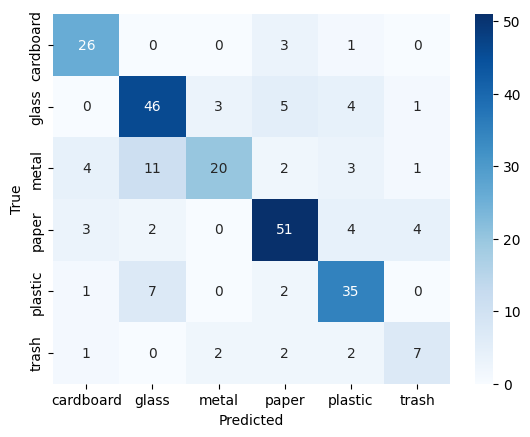

In [21]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()